### Импорты

In [1]:
import pandas as pd
import torch
import numpy as np
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import re
import pandas as pd 
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, random_split, Dataset
import os
import torch.nn.functional as F
from torch import nn, optim
from rouge_score import rouge_scorer
from transformers import BertTokenizerFast
import evaluate
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from typing import Tuple, List, Optional
from sklearn.model_selection import train_test_split
import pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json
import tempfile
from tqdm import tqdm as tqdm_auto
from config import PATHS, MODEL_CONFIG, TRAINING_CONFIG

ModuleNotFoundError: No module named 'rouge_score'

In [2]:

pd.set_option('display.max_colwidth', None)


### Деление на строки и очистка

In [3]:
# читаем текст из файла
with open(r"C:\Users\Alexandra\Desktop\text_autocompletion\data\raw_dataset.csv", "r", encoding="utf-8") as f:
    text = f.read()

# Разделяем текст на твиты: каждый твит начинается с @username и до следующего юзернейма
tweets_raw = re.split(r'(?<=\n)(?=@\w+\s)|^(?=@\w+\s)', text, flags=re.MULTILINE)

# Убираем пустые строки и лишние пробелы
tweets_cleaned = [tw.strip() for tw in tweets_raw if tw.strip()]

# Создаём DataFrame
df = pd.DataFrame(tweets_cleaned, columns=["text"])

# Вывод первых 10 твитов
print(f"Количество твитов после разделения: {len(df)}")
df.head(10)


Количество твитов после разделения: 688679


,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D\nis upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!"
1,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds\nmy whole body feels itchy and like its on fire
2,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
3,@Kwesidei not the whole crew \nNeed a hug
4,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
5,@Tatiana_K nope they didn't have it
6,@twittera que me muera ? \nspring break in plain city... it's snowing \nI just re-pierced my ears
7,@caregiving I couldn't bear to watch it. And I thought the UA loss was embarrassing . . . . .
8,"@octolinz16 It it counts, idk why I did either. you never talk to me anymore"
9,"@smarrison i would've been the first, but i didn't have a gun. not really though, zac snyder's just a doucheclown."


In [ ]:

# Функция предобработки твита
def preprocess_text(text: str) -> str:
    # Удаляем юзернеймы
    text = re.sub(r'@\w+\s+', '', text)
    # Удаляем ссылки
    text = re.sub(r"(https?://\S+|www\.\S+)", "", text)
    # Lowercase
    text = text.lower()
    # Убираем всё кроме латиницы, цифр, важных знаков препинания и пробелов
    text = re.sub(r"[^a-z0-9\s\.,!?']", "", text)
    # Нормализация пробелов
    text = re.sub(r"\s+", " ", text).strip()
    return text


df["text_clean"] = df["text"].apply(preprocess_text)

# Убираем пустые строки
df = df[df["text_clean"].str.strip() != ""]

df.head(10)


,text,text_clean
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D\nis upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!","awww, that's a bummer. you shoulda got david carr of third day to do it. d is upset that he can't update his facebook by texting it... and might cry as a result school today also. blah!"
1,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds\nmy whole body feels itchy and like its on fire,i dived many times for the ball. managed to save 50 the rest go out of bounds my whole body feels itchy and like its on fire
2,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.","no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there."
3,@Kwesidei not the whole crew \nNeed a hug,not the whole crew need a hug
4,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?","hey long time no see! yes.. rains a bit ,only a bit lol , i'm fine thanks , how's you ?"
5,@Tatiana_K nope they didn't have it,nope they didn't have it
6,@twittera que me muera ? \nspring break in plain city... it's snowing \nI just re-pierced my ears,que me muera ? spring break in plain city... it's snowing i just repierced my ears
7,@caregiving I couldn't bear to watch it. And I thought the UA loss was embarrassing . . . . .,i couldn't bear to watch it. and i thought the ua loss was embarrassing . . . . .
8,"@octolinz16 It it counts, idk why I did either. you never talk to me anymore","it it counts, idk why i did either. you never talk to me anymore"
9,"@smarrison i would've been the first, but i didn't have a gun. not really though, zac snyder's just a doucheclown.","i would've been the first, but i didn't have a gun. not really though, zac snyder's just a doucheclown."



Статистика по количеству слов в тексте:
Среднее: 29.21
Медиана: 22.00
5-й перцентиль: 4.00
95-й перцентиль: 81.00


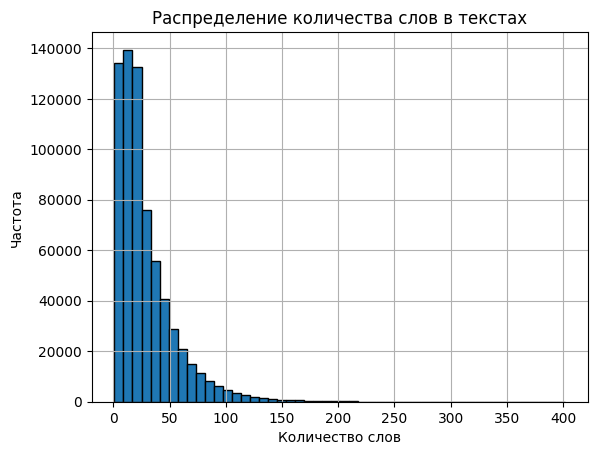

In [5]:

#  Статистика по количеству слов
word_counts = [len(text.split()) for text in df["text_clean"]]


print("\nСтатистика по количеству слов в тексте:")
print(f"Среднее: {np.mean(word_counts):.2f}")
print(f"Медиана: {np.median(word_counts):.2f}")
print(f"5-й перцентиль: {np.percentile(word_counts, 5):.2f}")
print(f"95-й перцентиль: {np.percentile(word_counts, 95):.2f}")

# Гистограмма распределения длины
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title("Распределение количества слов в текстах")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

###  Токенизация, подготовка X, y, сплит на трейн-валидацию-тест

In [6]:
"""
Токенизация и разбиение данных на train/val/test.
"""

# Dataset с Fast Tokenizer


class TextGenerationDataset(Dataset):
    """
    Dataset для генерации текста с поддержкой быстрой токенизации.
    Разбивает текст на prefix и target для обучения модели автодополнения.
    """
    
    def __init__(
        self, 
        texts: List[str], 
        tokenizer: BertTokenizerFast,
        max_length: int = 64,
        min_length: int = 16
    ):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.min_length = min_length
        
        self.samples = []
        self.word_boundaries = []
        
        # Батчевая токенизация - быстрее
        print("Токенизация батчами...")
        batch_size = 1000
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Батчевая токенизация
            encodings = self.tokenizer.batch_encode_plus(
                batch_texts,
                add_special_tokens=True,
                max_length=max_length,
                truncation=True,
                return_tensors=None
            )
            
            for tokens in encodings['input_ids']:
                if len(tokens) >= min_length:
                    # Находим границы слов
                    tokenized_text = self.tokenizer.convert_ids_to_tokens(tokens)
                    word_starts = [0]
                    
                    for j, token in enumerate(tokenized_text[1:], 1):
                        if not token.startswith('##') and token != '[SEP]':
                            word_starts.append(j)
                    
                    if len(tokens) - 1 not in word_starts:
                        word_starts.append(len(tokens) - 1)
                    
                    self.samples.append(tokens)
                    self.word_boundaries.append(word_starts)
        
        print(f"Загружено {len(self.samples)} строк")
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        tokens = self.samples[idx]
        word_starts = self.word_boundaries[idx]
        seq_len = len(tokens)
        
        target_split = int(seq_len * 0.75)
        split_point = min(word_starts, key=lambda x: abs(x - target_split))
        split_point = max(split_point, 1)
        
        prefix = tokens[:split_point]
        target = tokens[split_point:]
        
        prefix_len = int(self.max_length * 0.75)
        target_len = self.max_length - prefix_len
        
        if len(prefix) < prefix_len:
            prefix = prefix + [self.tokenizer.pad_token_id] * (prefix_len - len(prefix))
        elif len(prefix) > prefix_len:
            valid_boundaries = [w for w in word_starts if w <= prefix_len]
            if valid_boundaries:
                cut_point = max(valid_boundaries)
                prefix = tokens[:cut_point]
                target = tokens[cut_point:]
                if len(prefix) < prefix_len:
                    prefix = prefix + [self.tokenizer.pad_token_id] * (prefix_len - len(prefix))
        
        original_target_len = len(target)
        if len(target) < target_len:
            target = target + [self.tokenizer.pad_token_id] * (target_len - len(target))
        else:
            target = target[:target_len]
        
        attention_mask = [1] * min(original_target_len, target_len) + [0] * max(0, target_len - original_target_len)
        
        return (
            torch.tensor(prefix, dtype=torch.long),
            torch.tensor(target, dtype=torch.long),
            torch.tensor(attention_mask, dtype=torch.float)
        )


# Функции для работы с данными


def split_data(
    df: pd.DataFrame,
    text_column: str = 'text'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Разбивает DataFrame на train, validation и test выборки.
    """
    df_shuffled = df.sample(frac=1, random_state=TRAINING_CONFIG['random_state']).reset_index(drop=True)
    
    train_df, temp_df = train_test_split(
        df_shuffled,
        test_size=(TRAINING_CONFIG['val_ratio'] + TRAINING_CONFIG['test_ratio']),
        random_state=TRAINING_CONFIG['random_state']
    )
    
    val_size_adjusted = TRAINING_CONFIG['val_ratio'] / (TRAINING_CONFIG['val_ratio'] + TRAINING_CONFIG['test_ratio'])
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(1 - val_size_adjusted),
        random_state=TRAINING_CONFIG['random_state']
    )
    
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    return train_df, val_df, test_df


#  Параметр device принимает torch.device
def create_and_save_datasets(
    df: pd.DataFrame,
    text_column: str = 'text',
    device: torch.device = None
):
    """
    Создаёт datasets, dataloaders и сохраняет их на диск.
    
    Args:
        df: DataFrame с текстами
        text_column: название колонки с текстом
        device: torch.device объект (не строка!)
    """
   
    
    # Создаём директорию
    os.makedirs(PATHS['split_dir'], exist_ok=True)
    
    # Создаем torch.device объект, если не передан 
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("CPU")
    
    print("\nРазбиение данных...")
    train_df, val_df, test_df = split_data(df, text_column)
    
    print("\nЗагрузка Fast токенизатора...")
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    
    print("\nСоздание datasets...")
    train_texts = train_df[text_column].tolist()
    val_texts = val_df[text_column].tolist()
    test_texts = test_df[text_column].tolist()
    
    print("Train dataset:")
    train_dataset = TextGenerationDataset(
        train_texts, 
        tokenizer, 
        MODEL_CONFIG['max_length'], 
        MODEL_CONFIG['min_length']
    )
    
    print("Val dataset:")
    val_dataset = TextGenerationDataset(
        val_texts, 
        tokenizer, 
        MODEL_CONFIG['max_length'], 
        MODEL_CONFIG['min_length']
    )
    
    print("Test dataset:")
    test_dataset = TextGenerationDataset(
        test_texts, 
        tokenizer, 
        MODEL_CONFIG['max_length'], 
        MODEL_CONFIG['min_length']
    )
    
    print("\nСоздание dataloaders...")
    train_loader = DataLoader(
        train_dataset,
        batch_size=TRAINING_CONFIG['batch_size'],
        shuffle=True,
        num_workers=TRAINING_CONFIG['num_workers'],
        pin_memory=(device.type == 'cuda' and TRAINING_CONFIG['pin_memory'])
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=TRAINING_CONFIG['batch_size'],
        shuffle=False,
        num_workers=TRAINING_CONFIG['num_workers'],
        pin_memory=(device.type == 'cuda' and TRAINING_CONFIG['pin_memory'])
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=TRAINING_CONFIG['batch_size'],
        shuffle=False,
        num_workers=TRAINING_CONFIG['num_workers'],
        pin_memory=(device.type == 'cuda' and TRAINING_CONFIG['pin_memory'])
    )
    
    print("\nСохранение...")
    with open(PATHS['train_dataset'], 'wb') as f:
        pickle.dump(train_dataset, f)
    
    with open(PATHS['val_dataset'], 'wb') as f:
        pickle.dump(val_dataset, f)
    
    with open(PATHS['test_dataset'], 'wb') as f:
        pickle.dump(test_dataset, f)
    
    with open(PATHS['tokenizer'], 'wb') as f:
        pickle.dump(tokenizer, f)
    
    print(f"✓ Сохранено в: {PATHS['split_dir']}")
    
    return train_loader, val_loader, test_loader, tokenizer, device



# Главная функция


def main():
    """Основная функция для создания и сохранения datasets."""
    
    print("=" * 60)
    print("Создание datasets для обучения модели")
    print("=" * 60)
    
    print(f"\nЗагрузка данных из: {PATHS['clean_data']}")
    df = pd.read_csv(PATHS['clean_data'], encoding='utf-8')
    print(f"Загружено строк: {len(df)}")
    
    # Передаем torch.device объект вместо строки 'cuda' 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, val_loader, test_loader, tokenizer, device = create_and_save_datasets(
        df=df,
        text_column='text',
        device=device  # Правильно: torch.device объект
    )
    
    
    print("\n" + "=" * 60)
    print("✓ Готово!")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    print(f"  Test batches: {len(test_loader)}")
    print(f"  Device: {device}")
    print("=" * 60)


if __name__ == "__main__":
    main()

Создание datasets для обучения модели

Загрузка данных из: C:\Users\Alexandra\Desktop\text_autocompletion\data\clean_dataset.csv
Загружено строк: 688588
GPU: NVIDIA GeForce RTX 3060

Разбиение данных...
Train: 550870, Val: 68859, Test: 68859

Загрузка Fast токенизатора...

Создание datasets...
Train dataset:
Токенизация батчами...
Загружено 442643 строк
Val dataset:
Токенизация батчами...
Загружено 55362 строк
Test dataset:
Токенизация батчами...
Загружено 55267 строк

Создание dataloaders...

Сохранение...
✓ Сохранено в: C:\Users\Alexandra\Desktop\text_autocompletion\data\split

✓ Готово!
  Train batches: 3459
  Val batches: 433
  Test batches: 432
  Device: cuda


### Подготовка LSTM

In [ ]:
"""
LSTM модель для генерации продолжения текста.
"""

from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from config import MODEL_CONFIG


class LSTMTextGenerator(nn.Module):
    """
    LSTM модель для генерации продолжения текста (1/4 последовательности).
    """
    
    def __init__(
        self,
        vocab_size: int = None,
        embedding_dim: int = None,
        hidden_size: int = None,
        num_layers: int = None,
        dropout: float = None,
        pad_token_id: int = None
    ):
        """
        Args:
            vocab_size: размер словаря (30522 для BERT)
            embedding_dim: размерность embedding'ов
            hidden_size: размер hidden state LSTM
            num_layers: количество LSTM слоёв
            dropout: dropout rate
            pad_token_id: ID токена padding
        """
        super(LSTMTextGenerator, self).__init__()
        
        # Используем значения из конфига, если параметры не переданы
        self.vocab_size = vocab_size or MODEL_CONFIG['vocab_size']
        self.embedding_dim = embedding_dim or MODEL_CONFIG['embedding_dim']
        self.hidden_size = hidden_size or MODEL_CONFIG['hidden_size']
        self.num_layers = num_layers or MODEL_CONFIG['num_layers']
        dropout = dropout if dropout is not None else MODEL_CONFIG['dropout']
        self.pad_token_id = pad_token_id if pad_token_id is not None else MODEL_CONFIG['pad_token_id']
        
        # Embedding слой
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=self.pad_token_id
        )
        
        # LSTM слои
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=dropout if self.num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout перед выходным слоем
        self.dropout = nn.Dropout(dropout)
        
        # Выходной fully connected слой
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
        
        # Инициализация весов
        self._init_weights()
    
    def _init_weights(self):
        """Инициализация весов модели умным способом - через Xavier."""
        # Embedding
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        
        # LSTM
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
        # FC layer
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(
        self,
        input_ids: torch.Tensor,
        hidden: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Forward pass.
        
        Args:
            input_ids: [batch_size, seq_len] - входные токены
            hidden: опциональное начальное hidden state
        
        Returns:
            logits: [batch_size, seq_len, vocab_size] - logits для каждой позиции
            hidden: (h_n, c_n) - финальное hidden state
        """
        # Embedding: [batch_size, seq_len, embedding_dim]
        embedded = self.embedding(input_ids)
        
        # LSTM: [batch_size, seq_len, hidden_size]
        lstm_out, hidden = self.lstm(embedded, hidden)
        
        # Dropout
        lstm_out = self.dropout(lstm_out)
        
        # FC layer: [batch_size, seq_len, vocab_size]
        logits = self.fc(lstm_out)
        
        return logits, hidden
    
    def generate(
        self,
        prefix: torch.Tensor,
        max_length: int,
        temperature: float = None,
        top_k: int = None,
        repetition_penalty: float = None,
        pad_token_id: int = None,
        eos_token_id: int = 102  # [SEP] token для BERT
    ) -> torch.Tensor:
        """
        Генерирует продолжение текста с защитой от повторений.
        
        Args:
            prefix: [batch_size, prefix_len] - префикс (3/4 текста)
            max_length: длина генерации (1/4 текста)
            temperature: температура для sampling (выше = разнообразнее)
            top_k: размер top-k filtering
            repetition_penalty: штраф за повторения (>1 = сильнее штраф)
            pad_token_id: ID padding токена
            eos_token_id: ID токена конца последовательности
        
        Returns:
            generated: [batch_size, max_length] - сгенерированные токены
        """
        # Используем значения из конфига, если параметры не переданы
        temperature = temperature if temperature is not None else MODEL_CONFIG['temperature']
        top_k = top_k if top_k is not None else MODEL_CONFIG['top_k']
        repetition_penalty = repetition_penalty if repetition_penalty is not None else MODEL_CONFIG['repetition_penalty']
        pad_token_id = pad_token_id if pad_token_id is not None else self.pad_token_id
        
        self.eval()
        batch_size = prefix.size(0)
        device = prefix.device
        
        # Получаем hidden state от префикса (3/4 текста)
        with torch.no_grad():
            _, hidden = self.forward(prefix)
        
        #  Находим последний НЕ-PAD токен в каждой последовательности
        mask = (prefix != pad_token_id)  # [batch_size, seq_len]
        lengths = mask.sum(dim=1)  # Реальная длина каждой последовательности
        
        # Проверка: если вся последовательность из PAD (не должно быть, но на всякий случай)
        lengths = torch.clamp(lengths, min=1)
        
        # Извлекаем последний реальный токен для каждого примера в батче

### Оценка архитектуры модели

Опытном бутем было проверено, что:
- target_len - длина генерируемой последовательности должна быть приблизительно 16. Этот вывод был сделано после анализа длин текстов в датасете.
- embedding_dim=256, hidden_size=512,num_layers=2 и 5 эпох дают приблизитеьно такое же качество на текущих данных, как 10 эпох и 3 скрытых слоя. Так что оставляем более легковесные параметры.
- если использовать argmax, а не top-k при генерации следующего токена, то получается очень плохой результат. Поэтому в модель интегрированы следующие особенности генерации с защитой от повторений:

1) Temperature sampling - контролирует "креативность"
2) Top-k filtering - выбирает из топ-50 токенов
3) Repetition penalty - штрафует повторяющиеся токены


Оптимизация:
1) Xavier инициализация для стабильного обучения
2) Dropout для регуляризации
3) Padding aware (игнорирует pad токены)
4) NLP-шный классический оптимизатов Adam

In [8]:
if __name__ == "__main__":
    # Параметры
    vocab_size = 30522  # BERT vocab size
    batch_size = 4
    prefix_len = 48  # 75% от 64
    target_len = 16  # 25% от 64
    
    # Создаём модель
    model = LSTMTextGenerator(
        vocab_size=vocab_size,
        embedding_dim=256,
        hidden_size=512,
        num_layers=2,
        dropout=0.2
    )
    
    print("="*60)
    print("АРХИТЕКТУРА МОДЕЛИ")
    print("="*60)
    print(f"Параметров: {model.get_num_params():,}")
    print(f"Vocab size: {vocab_size}")
    print(f"Embedding dim: 256")
    print(f"Hidden size: 512")
    print(f"Num layers: 2")
    print(f"Dropout: 0.2")
    print("="*60)
    
    # Тестовые данные
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    prefix = torch.randint(0, vocab_size, (batch_size, prefix_len)).to(device)
    target = torch.randint(0, vocab_size, (batch_size, target_len)).to(device)
    
    # Forward pass
    logits, hidden = model(prefix)
    print(f"\nТест Forward Pass:")
    print(f"Input shape:  {prefix.shape}")
    print(f"Logits shape: {logits.shape}")  # [4, 48, 30522]
    
    # Генерация
    generated = model.generate(
        prefix, 
        max_length=16, 
        temperature=0.8, 
        top_k=50,
        repetition_penalty=1.2
    )
    print(f"\nТест Generation:")
    print(f"Generated shape: {generated.shape}")  # [4, 16]
    
    print("\nМодель готова к обучению")

АРХИТЕКТУРА МОДЕЛИ
Параметров: 27,149,626
Vocab size: 30522
Embedding dim: 256
Hidden size: 512
Num layers: 2
Dropout: 0.2

Тест Forward Pass:
Input shape:  torch.Size([4, 48])
Logits shape: torch.Size([4, 48, 30522])

Тест Generation:
Generated shape: torch.Size([4, 16])

Модель готова к обучению


In [ ]:
"""
Обучение LSTM модели с ROUGE метриками.
"""

import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from rouge_score import rouge_scorer
from src.dataset import TextGenerationDataset 
from src.lstm_model import LSTMTextGenerator
from config import PATHS, MODEL_CONFIG, TRAINING_CONFIG


def get_last_real_token(prefix, pad_token_id):
    """
    Находит последний НЕ-PAD токен в каждой последовательности батча.
    
    Args:
        prefix: [batch_size, seq_len] - префикс с возможным padding
        pad_token_id: ID токена padding
    
    Returns:
        last_tokens: [batch_size, 1] - последние реальные токены
    """
    batch_size = prefix.size(0)
    device = prefix.device
    
    # Маска реальных токенов (не PAD)
    mask = (prefix != pad_token_id)  # [batch_size, seq_len]
    
    # Длина каждой последовательности
    lengths = mask.sum(dim=1)  # [batch_size]
    
    # Защита от полностью PAD последовательностей
    lengths = torch.clamp(lengths, min=1)
    
    # Индексы последних реальных токенов
    indices = lengths - 1  # [batch_size]
    
    # Извлекаем последние реальные токены
    last_tokens = prefix[torch.arange(batch_size, device=device), indices]
    
    return last_tokens.unsqueeze(1)  # [batch_size, 1]


# Загрузка данных

os.makedirs(PATHS['models_dir'], exist_ok=True)

print("Загрузка данных...")
with open(PATHS['train_dataset'], 'rb') as f:
    train_dataset = pickle.load(f)
with open(PATHS['val_dataset'], 'rb') as f:
    val_dataset = pickle.load(f)
with open(PATHS['tokenizer'], 'rb') as f:
    tokenizer = pickle.load(f)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset, 
    batch_size=TRAINING_CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=TRAINING_CONFIG['num_workers']
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=TRAINING_CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=TRAINING_CONFIG['num_workers']
)


# Создание модели

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = LSTMTextGenerator(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=MODEL_CONFIG['embedding_dim'],
    hidden_size=MODEL_CONFIG['hidden_size'],
    num_layers=MODEL_CONFIG['num_layers'],
    dropout=MODEL_CONFIG['dropout'],
    pad_token_id=tokenizer.pad_token_id
).to(device)

print(f"Параметров: {model.get_num_params():,}\n")


# Оптимизация

optimizer = optim.Adam(
    model.parameters(), 
    lr=TRAINING_CONFIG['learning_rate'], 
    weight_decay=TRAINING_CONFIG['weight_decay']
)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=TRAINING_CONFIG['scheduler_factor'], 
    patience=TRAINING_CONFIG['scheduler_patience']
)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='none')
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


# Обучение

best_val_loss = float('inf')

for epoch in range(1, TRAINING_CONFIG['num_epochs'] + 1):
    # Train
    model.train()
    train_loss = 0
    for prefix, target, mask in tqdm(train_loader, desc=f"Epoch {epoch}"):
        prefix, target, mask = prefix.to(device), target.to(device), mask.to(device)
        
        optimizer.zero_grad()
        _, hidden = model(prefix)
        
        #  Берём последний реальный токен, а не PAD
        last_real_token = get_last_real_token(prefix, tokenizer.pad_token_id)
        decoder_input = torch.cat([last_real_token, target[:, :-1]], dim=1)
        
        logits, _ = model(decoder_input, hidden)
        
        loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        loss = (loss * mask.reshape(-1)).sum() / mask.reshape(-1).sum()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), TRAINING_CONFIG['grad_clip'])
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Val с ROUGE
    model.eval()
    val_loss = 0
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    with torch.no_grad():
        for prefix, target, mask in val_loader:
            prefix, target, mask = prefix.to(device), target.to(device), mask.to(device)
            
            # Loss
            _, hidden = model(prefix)
            
            # ИСПРАВЛЕНИЕ: Берём последний реальный токен
            last_real_token = get_last_real_token(prefix, tokenizer.pad_token_id)
            decoder_input = torch.cat([last_real_token, target[:, :-1]], dim=1)
            
            logits, _ = model(decoder_input, hidden)
            
            loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            loss = (loss * mask.reshape(-1)).sum() / mask.reshape(-1).sum()
            val_loss += loss.item()
            
            # ROUGE
            if len(rouge_scores['rouge1']) < TRAINING_CONFIG['num_rouge_samples']:
                generated = model.generate(
                    prefix[:32],
                    max_length=target.size(1),
                    temperature=MODEL_CONFIG['temperature'],
                    top_k=MODEL_CONFIG['top_k'],
                    repetition_penalty=MODEL_CONFIG['repetition_penalty'],
                    pad_token_id=tokenizer.pad_token_id
                )
                
                for i in range(min(32, prefix.size(0))):
                    target_text = tokenizer.decode(target[i].cpu().tolist(), skip_special_tokens=True)
                    generated_text = tokenizer.decode(generated[i].cpu().tolist(), skip_special_tokens=True)
                    
                    if len(target_text.strip()) > 0 and len(generated_text.strip()) > 0:
                        scores = scorer.score(target_text, generated_text)
                        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
                        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
                        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)
    
    val_loss /= len(val_loader)
    perplexity = np.exp(val_loss)
    scheduler.step(val_loss)
    
    # Средние ROUGE
    avg_rouge1 = np.mean(rouge_scores['rouge1']) if rouge_scores['rouge1'] else 0.0
    avg_rouge2 = np.mean(rouge_scores['rouge2']) if rouge_scores['rouge2'] else 0.0
    avg_rougeL = np.mean(rouge_scores['rougeL']) if rouge_scores['rougeL'] else 0.0
    
    print(f"Epoch {epoch}: Train={train_loss:.4f}, Val={val_loss:.4f}, PPL={perplexity:.2f}")
    print(f"  ROUGE-1={avg_rouge1:.4f}, ROUGE-2={avg_rouge2:.4f}, ROUGE-L={avg_rougeL:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), PATHS['best_model'])
        print("  Модель сохранена")

print("\nОбучение завершено!")

Загрузка данных...
Train: 442643, Val: 55362
Device: cuda
Параметров: 27,149,626



Epoch 1:   0%|          | 0/3459 [00:00<?, ?it/s]

Epoch 1: Train=5.6798, Val=4.9381, PPL=139.51
  ROUGE-1=0.0622, ROUGE-2=0.0031, ROUGE-L=0.0569
  Модель сохранена


Epoch 2:   0%|          | 0/3459 [00:00<?, ?it/s]

Epoch 2: Train=4.8291, Val=4.6869, PPL=108.51
  ROUGE-1=0.0649, ROUGE-2=0.0035, ROUGE-L=0.0595
  Модель сохранена


Epoch 3:   0%|          | 0/3459 [00:00<?, ?it/s]

Epoch 3: Train=4.6536, Val=4.5562, PPL=95.22
  ROUGE-1=0.0655, ROUGE-2=0.0032, ROUGE-L=0.0606
  Модель сохранена


Epoch 4:   0%|          | 0/3459 [00:00<?, ?it/s]

Epoch 4: Train=4.5659, Val=4.5333, PPL=93.06
  ROUGE-1=0.0672, ROUGE-2=0.0043, ROUGE-L=0.0619
  Модель сохранена


Epoch 5:   0%|          | 0/3459 [00:00<?, ?it/s]

Epoch 5: Train=4.5098, Val=4.4495, PPL=85.59
  ROUGE-1=0.0686, ROUGE-2=0.0053, ROUGE-L=0.0639
  Модель сохранена

Обучение завершено!


In [ ]:
"""
Просмотр примеров генерации из validation set.
"""

# Параметры

example_params = {
    'num_examples': 10,
    'temperature': 0.8,
    'top_k': 50,
    'repetition_penalty': 1.2
}


# Загрузка данных и модели


print("Загрузка данных...")
with open(PATHS['val_dataset'], 'rb') as f:
    val_dataset = pickle.load(f)
with open(PATHS['tokenizer'], 'rb') as f:
    tokenizer = pickle.load(f)

val_loader = DataLoader(val_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Загружаем лучшую модель
model = LSTMTextGenerator(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=MODEL_CONFIG['embedding_dim'],
    hidden_size=MODEL_CONFIG['hidden_size'],
    num_layers=MODEL_CONFIG['num_layers'],
    dropout=MODEL_CONFIG['dropout'],
    pad_token_id=tokenizer.pad_token_id
).to(device)

model.load_state_dict(torch.load(PATHS['best_model']), weights_only=True)
model.eval()

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


# Генерация примеров


print("="*80)
print("ПРИМЕРЫ ГЕНЕРАЦИИ ИЗ VALIDATION SET")
print("="*80)

num_examples = example_params['num_examples']
examples_shown = 0
examples_data = []
rouge_values = {'rouge1': [], 'rouge2': [], 'rougeL': []}

with torch.no_grad():
    for prefix, target, mask in val_loader:
        if examples_shown >= num_examples:
            break
        
        prefix = prefix.to(device)
        target = target.to(device)
        
        # Генерируем
        generated = model.generate(
            prefix,
            max_length=target.size(1),
            temperature=example_params['temperature'],
            top_k=example_params['top_k'],
            repetition_penalty=example_params['repetition_penalty'],
            pad_token_id=tokenizer.pad_token_id
        )
        
        # Показываем примеры
        for i in range(min(prefix.size(0), num_examples - examples_shown)):
            prefix_text = tokenizer.decode(prefix[i].cpu().tolist(), skip_special_tokens=True)
            target_text = tokenizer.decode(target[i].cpu().tolist(), skip_special_tokens=True)
            generated_text = tokenizer.decode(generated[i].cpu().tolist(), skip_special_tokens=True)
            
            # ROUGE для примера
            if len(target_text.strip()) > 0 and len(generated_text.strip()) > 0:
                scores = scorer.score(target_text, generated_text)
                
                print(f"\n{'─'*80}")
                print(f"Пример {examples_shown + 1}:")
                print(f"{'─'*80}")
                print(f"Префикс (75%):    {prefix_text}")
                print(f"Ground Truth:     {target_text}")
                print(f"Сгенерировано:    {generated_text}")
                print(f"\nROUGE-1: {scores['rouge1'].fmeasure:.4f} | "
                      f"ROUGE-2: {scores['rouge2'].fmeasure:.4f} | "
                      f"ROUGE-L: {scores['rougeL'].fmeasure:.4f}")
                
                # Сохраняем как словарь
                examples_data.append({
                    'example_num': examples_shown + 1,
                    'prefix': prefix_text,
                    'ground_truth': target_text,
                    'generated': generated_text,
                    'rouge1': scores['rouge1'].fmeasure,
                    'rouge2': scores['rouge2'].fmeasure,
                    'rougeL': scores['rougeL'].fmeasure
                })
                
                rouge_values['rouge1'].append(scores['rouge1'].fmeasure)
                rouge_values['rouge2'].append(scores['rouge2'].fmeasure)
                rouge_values['rougeL'].append(scores['rougeL'].fmeasure)
                
                examples_shown += 1
            
            if examples_shown >= num_examples:
                break

# Средние ROUGE
print(f"\n{'='*80}")
print("СРЕДНИЕ ROUGE ДЛЯ ПРИМЕРОВ:")
print(f"  ROUGE-1: {np.mean(rouge_values['rouge1']):.4f}")
print(f"  ROUGE-2: {np.mean(rouge_values['rouge2']):.4f}")
print(f"  ROUGE-L: {np.mean(rouge_values['rougeL']):.4f}")
print(f"{'='*80}\n")

# Сохраняем примеры в JSON
examples_path = os.path.join(PATHS['models_dir'], 'validation_examples.json')
with open(examples_path, 'w', encoding='utf-8') as f:
    json.dump(examples_data, f, ensure_ascii=False, indent=2)

print(f"Примеры сохранены в: {examples_path}")

Загрузка данных...
Device: cuda


C:\Users\Alexandra\AppData\Local\Temp\ipykernel_14080\957172102.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATHS['best_model']))


ПРИМЕРЫ ГЕНЕРАЦИИ ИЗ VALIDATION SET

────────────────────────────────────────────────────────────────────────────────
Пример 1:
────────────────────────────────────────────────────────────────────────────────
Префикс (75%):    hi miley i love u so much! ur so amzing!!! plz replyfollow me
Ground Truth:     it would rlly mean alot
Сгенерировано:    ! i wanna see them in!

ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000

────────────────────────────────────────────────────────────────────────────────
Пример 2:
────────────────────────────────────────────────────────────────────────────────
Префикс (75%):    whhyy mom ' s gone. i already miss her but in week and a half she ' ll be here again so
Ground Truth:     .. yay! happiness again xd
Сгенерировано:    you will be ok, your love!

ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000

────────────────────────────────────────────────────────────────────────────────
Пример 3:
─────────────────────────────────────────────────────────────

### Промежуточный вывод: более-менее осмысленно. Я - человек - вряд ли такие текст дополнила бы лучше.

### Финальная оценка на тест-сете

In [ ]:
"""
Оценка LSTM модели на test set.
"""

# Загрузка данных и модели


print("Загрузка test set...")
with open(PATHS['test_dataset'], 'rb') as f:
    test_dataset = pickle.load(f)
with open(PATHS['tokenizer'], 'rb') as f:
    tokenizer = pickle.load(f)

test_loader = DataLoader(
    test_dataset, 
    batch_size=TRAINING_CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0
)
print(f"Test samples: {len(test_dataset)}")

# Загружаем модель
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = LSTMTextGenerator(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=MODEL_CONFIG['embedding_dim'],
    hidden_size=MODEL_CONFIG['hidden_size'],
    num_layers=MODEL_CONFIG['num_layers'],
    dropout=MODEL_CONFIG['dropout'],
    pad_token_id=tokenizer.pad_token_id
).to(device)

model.load_state_dict(torch.load(PATHS['best_model']), weights_only=True))
model.eval()

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='none')
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


# Оценка на test set


test_loss = 0
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

print("\nОценка на test set...")

with torch.no_grad():
    for prefix, target, mask in tqdm(test_loader, desc="Testing"):
        prefix, target, mask = prefix.to(device), target.to(device), mask.to(device)
        
        # Loss
        _, hidden = model(prefix)
        decoder_input = torch.cat([prefix[:, -1:], target[:, :-1]], dim=1)
        logits, _ = model(decoder_input, hidden)
        
        loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        loss = (loss * mask.reshape(-1)).sum() / mask.reshape(-1).sum()
        test_loss += loss.item()
        
        # ROUGE
        if len(rouge_scores['rouge1']) < TRAINING_CONFIG['num_rouge_samples']:
            generated = model.generate(
                prefix[:32],
                max_length=target.size(1),
                temperature=MODEL_CONFIG['temperature'],
                top_k=MODEL_CONFIG['top_k'],
                repetition_penalty=MODEL_CONFIG['repetition_penalty'],
                pad_token_id=tokenizer.pad_token_id
            )
            
            for i in range(min(32, prefix.size(0))):
                target_text = tokenizer.decode(target[i].cpu().tolist(), skip_special_tokens=True)
                generated_text = tokenizer.decode(generated[i].cpu().tolist(), skip_special_tokens=True)
                
                if len(target_text.strip()) > 0 and len(generated_text.strip()) > 0:
                    scores = scorer.score(target_text, generated_text)
                    rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
                    rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
                    rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

test_loss /= len(test_loader)
test_perplexity = np.exp(test_loss)

# Средние метрики
avg_rouge1 = np.mean(rouge_scores['rouge1'])
avg_rouge2 = np.mean(rouge_scores['rouge2'])
avg_rougeL = np.mean(rouge_scores['rougeL'])

std_rouge1 = np.std(rouge_scores['rouge1'])
std_rouge2 = np.std(rouge_scores['rouge2'])
std_rougeL = np.std(rouge_scores['rougeL'])

# Результаты
print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ НА TEST SET")
print("="*80)
print(f"Test Loss:       {test_loss:.4f}")
print(f"Test Perplexity: {test_perplexity:.2f}")
print(f"\nROUGE Scores (на {len(rouge_scores['rouge1'])} примерах):")
print(f"  ROUGE-1: {avg_rouge1:.4f} (±{std_rouge1:.4f})")
print(f"  ROUGE-2: {avg_rouge2:.4f} (±{std_rouge2:.4f})")
print(f"  ROUGE-L: {avg_rougeL:.4f} (±{std_rougeL:.4f})")
print("="*80)



# Примеры генерации


print("\nПРИМЕРЫ ГЕНЕРАЦИИ ИЗ TEST SET")
print("="*80)

num_examples = TRAINING_CONFIG['num_examples']
examples_shown = 0
examples_data = []

with torch.no_grad():
    for prefix, target, mask in test_loader:
        if examples_shown >= num_examples:
            break
        
        prefix = prefix.to(device)
        target = target.to(device)
        
        generated = model.generate(
            prefix,
            max_length=target.size(1),
            temperature=MODEL_CONFIG['temperature'],
            top_k=MODEL_CONFIG['top_k'],
            repetition_penalty=MODEL_CONFIG['repetition_penalty'],
            pad_token_id=tokenizer.pad_token_id
        )
        
        for i in range(min(prefix.size(0), num_examples - examples_shown)):
            prefix_text = tokenizer.decode(prefix[i].cpu().tolist(), skip_special_tokens=True)
            target_text = tokenizer.decode(target[i].cpu().tolist(), skip_special_tokens=True)
            generated_text = tokenizer.decode(generated[i].cpu().tolist(), skip_special_tokens=True)
            
            if len(target_text.strip()) > 0 and len(generated_text.strip()) > 0:
                scores = scorer.score(target_text, generated_text)
                
                print(f"\nПример {examples_shown + 1}:")
                print(f"Префикс: {prefix_text}")
                print(f"Ground Truth: {target_text}")
                print(f"Генерация: {generated_text}")
                print(f"ROUGE: R1={scores['rouge1'].fmeasure:.3f}, "
                      f"R2={scores['rouge2'].fmeasure:.3f}, "
                      f"RL={scores['rougeL'].fmeasure:.3f}")
                print("─"*80)
                
                # Сохраняем как словарь
                examples_data.append({
                    'example_num': examples_shown + 1,
                    'prefix': prefix_text,
                    'ground_truth': target_text,
                    'generated': generated_text,
                    'rouge1': scores['rouge1'].fmeasure,
                    'rouge2': scores['rouge2'].fmeasure,
                    'rougeL': scores['rougeL'].fmeasure
                })
                
                examples_shown += 1
            
            if examples_shown >= num_examples:
                break

# Сохраняем примеры в JSON
with open(PATHS['test_examples'], 'w', encoding='utf-8') as f:
    json.dump(examples_data, f, ensure_ascii=False, indent=2)

print(f"\nПримеры сохранены в: {PATHS['test_examples']}")
print("Оценка завершена")

Загрузка test set...
Test samples: 55267
Device: cuda

Оценка на test set...


C:\Users\Alexandra\AppData\Local\Temp\ipykernel_14080\2771167583.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATHS['best_model']))


Testing:   0%|          | 0/432 [00:00<?, ?it/s]


РЕЗУЛЬТАТЫ НА TEST SET
Test Loss:       4.4529
Test Perplexity: 85.88

ROUGE Scores (на 2015 примерах):
  ROUGE-1: 0.0728 (±0.1084)
  ROUGE-2: 0.0063 (±0.0438)
  ROUGE-L: 0.0678 (±0.1028)

ПРИМЕРЫ ГЕНЕРАЦИИ ИЗ TEST SET

Пример 1:
Префикс: i ' m a guy. of course i ' d laugh at something like that.
Ground Truth: how are you today mona?
Генерация: yay all tomorrow.
ROUGE: R1=0.000, R2=0.000, RL=0.000
────────────────────────────────────────────────────────────────────────────────

Пример 2:
Префикс: ok so somehow ashwee managed to make a whole bottle of purple punky explode all over the bathroom and even some on the carpet i really want to keep watching evangelion or playing gta iv, but i keep passing out.
Ground Truth: maybe it ' s a sign i need sleep? but i dun wanna.
Генерация: good night, it was a great day! my birthday. going to sleep
ROUGE: R1=0.250, R2=0.000, RL=0.250
────────────────────────────────────────────────────────────────────────────────

Пример 3:
Префикс: i know, i kno

### Вывод: дополнение осмысленны. ROUGE низкая, но это неудивительно, т.к. в такиъх твиттах смысла не всегда много, тут perplexity и у человека высокая будет.

### Использование предобученного трансформера

In [12]:
"""
Сравнение с baseline: DistilGPT2.
"""


# Параметры для GPT2


gpt2_params = {
    'model_name': 'distilgpt2',
    'num_samples': 100,
    'max_new_tokens': 10,
    'split_ratio': 0.75
}


# Загрузка данных


print("Загрузка данных...")
with open(PATHS['val_dataset'], 'rb') as f:
    val_dataset = pickle.load(f)
with open(PATHS['tokenizer'], 'rb') as f:
    tokenizer = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Загрузка DistilGPT2


print("\nЗагрузка DistilGPT2...")
tokenizer_gpt = AutoTokenizer.from_pretrained(gpt2_params['model_name'])
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

model_gpt = AutoModelForCausalLM.from_pretrained(gpt2_params['model_name']).to(device)

generator = pipeline(
    "text-generation",
    model=model_gpt,
    tokenizer=tokenizer_gpt,
    device=0 if torch.cuda.is_available() else -1
)

rouge = evaluate.load("rouge")
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_gpt.pad_token_id, reduction='none')


# Функция генерации


def generate_continuation(text, max_new_tokens=10):
    """Генерирует продолжение текста (последние 25%)."""
    words = text.split()
    split_idx = int(len(words) * gpt2_params['split_ratio'])
    
    input_text = " ".join(words[:split_idx])
    target_text = " ".join(words[split_idx:])
    
    result = generator(
        input_text,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=MODEL_CONFIG['top_k'],
        temperature=MODEL_CONFIG['temperature']
    )
    
    generated_full = result[0]["generated_text"]
    generated_tail = generated_full[len(input_text):].strip()
    
    return input_text, target_text, generated_tail



# Подсчет loss на validation set


print("\nПодсчет loss на validation set...")
val_loader = DataLoader(val_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False, num_workers=0)

model_gpt.eval()
val_loss = 0

with torch.no_grad():
    for prefix, target, mask in tqdm(val_loader, desc="Computing loss"):
        # Токенизируем prefix для GPT2
        prefix_text_batch = [tokenizer.decode(p.tolist(), skip_special_tokens=True) for p in prefix]
        target_text_batch = [tokenizer.decode(t.tolist(), skip_special_tokens=True) for t in target]
        
        # Объединяем prefix + target для GPT2
        full_text_batch = [p + " " + t for p, t in zip(prefix_text_batch, target_text_batch)]
        
        # Токенизируем для GPT2
        inputs = tokenizer_gpt(full_text_batch, return_tensors='pt', padding=True, truncation=True, max_length=MODEL_CONFIG['max_length'])
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Forward pass
        outputs = model_gpt(**inputs, labels=inputs['input_ids'])
        val_loss += outputs.loss.item()

val_loss /= len(val_loader)
val_perplexity = np.exp(val_loss)

print(f"\nGPT2 Loss: {val_loss:.4f}")
print(f"GPT2 Perplexity: {val_perplexity:.2f}")

# Оценка ROUGE на validation set


print("\nОценка ROUGE на validation set...")

num_samples = gpt2_params['num_samples']
sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

all_preds, all_refs = [], []

for idx in tqdm(sample_indices, desc="DistilGPT2 Generation"):
    prefix, target, _ = val_dataset[idx]
    
    prefix_text = tokenizer.decode(prefix.tolist(), skip_special_tokens=True)
    target_text = tokenizer.decode(target.tolist(), skip_special_tokens=True)
    full_text = prefix_text + " " + target_text
    
    _, gt, pred = generate_continuation(full_text, max_new_tokens=gpt2_params['max_new_tokens'])
    
    all_preds.append(pred)
    all_refs.append(gt)

# ROUGE метрики
gpt_rouge = rouge.compute(predictions=all_preds, references=all_refs)

print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ DistilGPT2 НА VALIDATION SET")
print("="*80)
print(f"Loss:       {val_loss:.4f}")
print(f"Perplexity: {val_perplexity:.2f}")
print(f"ROUGE-1: {gpt_rouge['rouge1']:.4f}")
print(f"ROUGE-2: {gpt_rouge['rouge2']:.4f}")
print(f"ROUGE-L: {gpt_rouge['rougeL']:.4f}")
print("="*80)

# Примеры генерации


print("\nПРИМЕРЫ ГЕНЕРАЦИИ DistilGPT2:")
print("="*80)

examples_data = []
for i in range(min(5, num_samples)):
    idx = sample_indices[i]
    prefix, target, _ = val_dataset[idx]
    
    prefix_text = tokenizer.decode(prefix.tolist(), skip_special_tokens=True)
    target_text = tokenizer.decode(target.tolist(), skip_special_tokens=True)
    full_text = prefix_text + " " + target_text
    
    inp, gt, pred = generate_continuation(full_text, max_new_tokens=gpt2_params['max_new_tokens'])
    
    print(f"\nПример {i+1}:")
    print(f"Префикс: {inp}")
    print(f"Ground Truth: {gt}")
    print(f"GPT2: {pred}")
    print("─"*80)
    
    # Сохраняем как словарь
    examples_data.append({
        'example_num': i + 1,
        'prefix': inp,
        'ground_truth': gt,
        'gpt2_generated': pred
    })

# Сохраняем примеры в JSON
with open(PATHS['gpt2_examples'], 'w', encoding='utf-8') as f:
    json.dump(examples_data, f, ensure_ascii=False, indent=2)

print(f"\nПримеры сохранены в: {PATHS['gpt2_examples']}")
print("Готово")

Загрузка данных...
Device: cuda

Загрузка DistilGPT2...


Device set to use cuda:0



Подсчет loss на validation set...


Computing loss:   0%|          | 0/433 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.



GPT2 Loss: 7.4887
GPT2 Perplexity: 1787.65

Оценка ROUGE на validation set...


DistilGPT2 Generation:   0%|          | 0/100 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



РЕЗУЛЬТАТЫ DistilGPT2 НА VALIDATION SET
Loss:       7.4887
Perplexity: 1787.65
ROUGE-1: 0.0645
ROUGE-2: 0.0060
ROUGE-L: 0.0591

ПРИМЕРЫ ГЕНЕРАЦИИ DistilGPT2:

Пример 1:
Префикс: nice to tweet you! you ' ve got me singing quottonight i ' m gonna party like it ' s 1999... quot it
Ground Truth: won ' t get out of my head!
GPT2: ...



I am a long time
────────────────────────────────────────────────────────────────────────────────

Пример 2:
Префикс: brill poor rabbit. maybe we should get a frog as well
Ground Truth: to eat the flies?
GPT2: , then we can make a frog ourselves.
────────────────────────────────────────────────────────────────────────────────

Пример 3:
Префикс: ah yes, space is so limited here! must work with what i have!
Ground Truth: yours is looking great, too!
GPT2: if i have to try it, i will not
────────────────────────────────────────────────────────────────────────────────

Пример 4:
Префикс: cool. did i see something about a free lunch if i sign up for nbc4
Ground

### Выводы

- ROUGE-1 метрика низка у обеих моделей (обученная нами LSTM и DistilGPT2: 0.6 ROUGE1 у обеих), что указывает на сложность задачи точного воспроизведения текста. Это сложно даже для человека. Несмотря на, это результаты получились довольно адекватные, у нашей модели даже немного адекватнее DistilGPT2, на мой субъективный взгляд.
- DistilGPT2 показывает немного лучшие результаты по ROUGE-1,  что может быть связано с его предобучением на гораздо более объемном корпусе.  
- LSTM демонстрирует конкурентоспособные результаты, особенно учитывая её меньший размер и отсутствие предобучения.

Для нашего приложения можно рассчитывать на LSTM, особенно если дообучить ее на более логичных текстах и на большем корпусе.